In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [3]:
dataset_path = "./dataset"

In [4]:
# Parámetros
batch_size = 32
img_size = (224, 224)

# Crear datasets de entrenamiento y validación
train_dataset = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,  # 20% para validación
    subset="training",
    seed=123,  # Semilla para reproducibilidad
    image_size=img_size,
    batch_size=batch_size
)

val_dataset = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

Found 245 files belonging to 2 classes.
Using 196 files for training.
Found 245 files belonging to 2 classes.
Using 49 files for validation.


In [5]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])



In [6]:
# Preprocesar imágenes (normalización)
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

def prepare_dataset(ds):
    ds = ds.map(lambda x, y: (preprocess_input(x), y))
    ds = ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

train_dataset = prepare_dataset(train_dataset)
val_dataset = prepare_dataset(val_dataset)

In [7]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

# Cargar MobileNetV2 preentrenado
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Congelar las capas base

# Añadir capas de clasificación
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Clasificación binaria
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5527 - loss: 0.8588 - val_accuracy: 0.8163 - val_loss: 0.3494
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 817ms/step - accuracy: 0.7014 - loss: 0.4790 - val_accuracy: 0.8571 - val_loss: 0.2584
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 814ms/step - accuracy: 0.7972 - loss: 0.3963 - val_accuracy: 0.9592 - val_loss: 0.1872
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 818ms/step - accuracy: 0.8848 - loss: 0.2935 - val_accuracy: 1.0000 - val_loss: 0.1454
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 807ms/step - accuracy: 0.9325 - loss: 0.2059 - val_accuracy: 1.0000 - val_loss: 0.1349
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 804ms/step - accuracy: 0.9476 - loss: 0.2085 - val_accuracy: 1.0000 - val_loss: 0.0959
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 937ms/step - accuracy: 0.9558 - loss: 0.1525 - val_accuracy: 1.0000 - val_loss: 0.0786
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 848ms/step - accuracy: 0.9624 - loss: 0.1204 - val_accuracy: 1.0000 - val_loss: 0

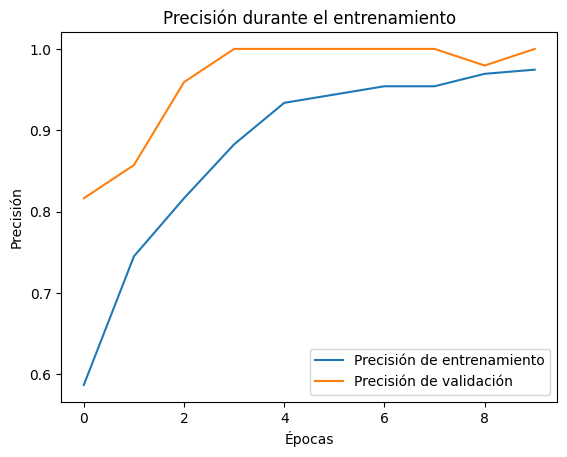

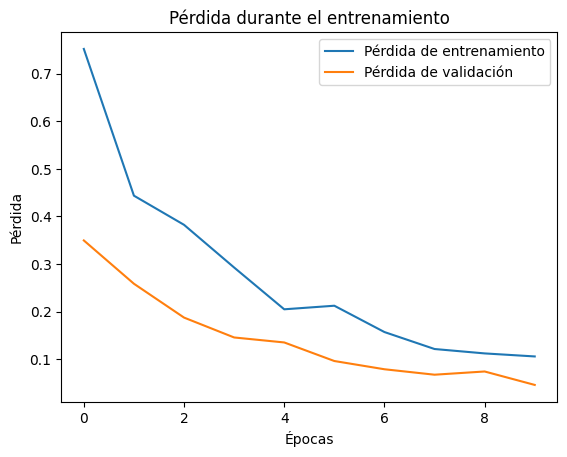

In [8]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)

# Graficar la precisión y pérdida
import matplotlib.pyplot as plt

# Graficar precisión
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Graficar pérdida
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


In [9]:
# Guardar el modelo completo (arquitectura + pesos)
model.save('modeloMejorado.h5')
